<a href="https://colab.research.google.com/github/AdsonRamos/if697-2020.2/blob/main/Projeto_IF697.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import geopandas

import math

from matplotlib import pyplot as plt

# Carregando dados

In [44]:
customers = pd.read_csv("datasets/olist_customers_dataset.csv", encoding="ISO-8859-1")
geolocation = pd.read_csv("datasets/olist_geolocation_dataset.csv", encoding="ISO-8859-1")
order_items = pd.read_csv("datasets/olist_order_items_dataset.csv", encoding="ISO-8859-1")
order_payments = pd.read_csv("datasets/olist_order_payments_dataset.csv", encoding="ISO-8859-1")
order_reviews = pd.read_csv("datasets/olist_order_reviews_dataset.csv", encoding="ISO-8859-1")
orders = pd.read_csv("datasets/olist_orders_dataset.csv", encoding="ISO-8859-1")
products = pd.read_csv("datasets/olist_products_dataset.csv", encoding="ISO-8859-1")
sellers = pd.read_csv("datasets/olist_sellers_dataset.csv", encoding="ISO-8859-1")

# Descrição inicial dos datasets

In [45]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [46]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [47]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [48]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [49]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [50]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [51]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [52]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


Podemos ver que o dataset de geolocalizações é o maior de todos, com mais de 1 milhão de entradas. No outro extremo, temos o de vendedores, com cerca de 3 mil.

A maioria das colunas não apresenta valores nulos, mas o dataset de resenhas tem as colunas `review_comment_title` e `review_comment_message` com muitos valores nulos. Também chama a atenção os datasets de produtos e pedidos, onde algumas colunas possuem poucos valores nulos.

# Estudo sobre o dataset de clientes

In [53]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [54]:
customers.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


<AxesSubplot:xlabel='Estados', ylabel='Clientes'>

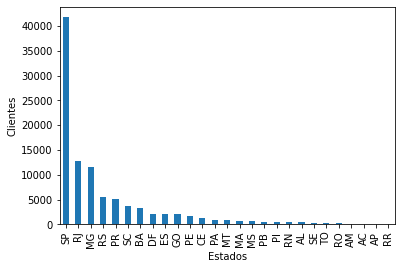

In [55]:
#Estados mais frequentes nos clientes
customers['customer_state'].value_counts().plot(kind='bar', ylabel='Clientes', xlabel='Estados')

## Agrupamento por regiões

In [56]:
sudeste = ['MG', 'RJ', 'RS', 'SP']
nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PI', 'PE', 'RN', 'SE']
sul = ['PR', 'RS', 'SC']
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'MS', 'GO', 'DF']

[Text(0.5, 1.0, 'Centro-Oeste')]

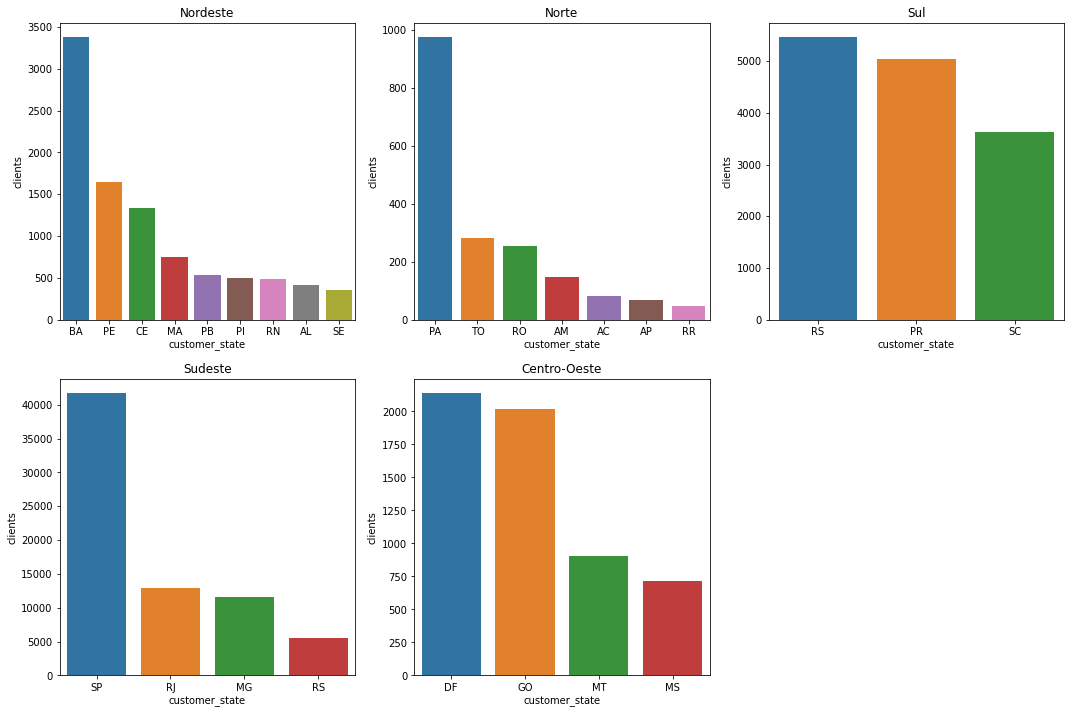

In [57]:
#Clientes distribuídos por regiões do país

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 12))
fig.delaxes(axes[1,2])

northeast_client_counts = customers[customers.customer_state.isin(nordeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
northeast_client_counts["customer_state"] = northeast_client_counts["customer_state"].astype('category')

north_client_counts = customers[customers.customer_state.isin(norte)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
north_client_counts["customer_state"] = north_client_counts["customer_state"].astype('category')

south_client_counts = customers[customers.customer_state.isin(sul)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
south_client_counts["customer_state"] = south_client_counts["customer_state"].astype('category')

southeast_client_counts = customers[customers.customer_state.isin(sudeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
southeast_client_counts["customer_state"] = southeast_client_counts["customer_state"].astype('category')

midwest_client_counts = customers[customers.customer_state.isin(centro_oeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
midwest_client_counts["customer_state"] = midwest_client_counts["customer_state"].astype('category')

sns.barplot(x='customer_state', y='clients', order=northeast_client_counts['customer_state'], data=northeast_client_counts, ax=axes[0][0]).set(title="Nordeste")
sns.barplot(x='customer_state', y='clients', order=north_client_counts['customer_state'], data=north_client_counts, ax=axes[0][1]).set(title="Norte")
sns.barplot(x='customer_state', y='clients', order=south_client_counts['customer_state'], data=south_client_counts, ax=axes[0][2]).set(title="Sul")
sns.barplot(x='customer_state', y='clients', order=southeast_client_counts['customer_state'], data=southeast_client_counts, ax=axes[1][0]).set(title="Sudeste")
sns.barplot(x='customer_state', y='clients', order=midwest_client_counts['customer_state'], data=midwest_client_counts, ax=axes[1][1]).set(title="Centro-Oeste")

# Estudo sobre as localizações

In [58]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [88]:
geolocation.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


In [103]:
world_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [104]:
points = geopandas.GeoDataFrame(geolocation, geometry=geopandas.points_from_xy(geolocation['geolocation_lng'], geolocation['geolocation_lat']))
points.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geometry
0,1037,-23.545621,-46.639292,sao paulo,SP,POINT (-46.63929 -23.54562)
1,1046,-23.546081,-46.644820,sao paulo,SP,POINT (-46.64482 -23.54608)
2,1046,-23.546129,-46.642951,sao paulo,SP,POINT (-46.64295 -23.54613)
3,1041,-23.544392,-46.639499,sao paulo,SP,POINT (-46.63950 -23.54439)
4,1035,-23.541578,-46.641607,sao paulo,SP,POINT (-46.64161 -23.54158)


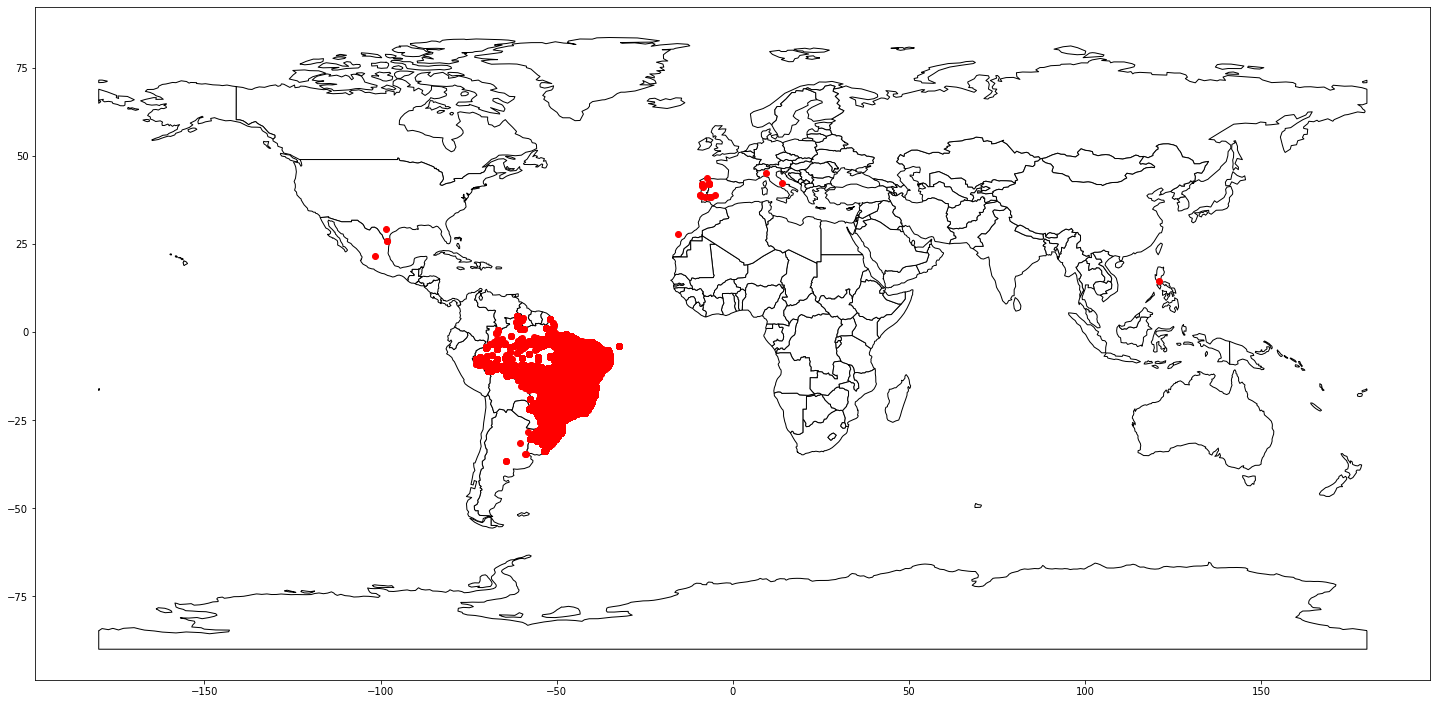

In [108]:
# Localização dos pedidos em relação ao mundo
ax = world_map.plot(color='white', edgecolor='black', figsize=(25,20))
points.plot(ax=ax, color='red')
plt.show()

In [178]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=4)
predictions = clf.fit_predict(geolocation[['geolocation_lng', 'geolocation_lat']])
predictions[predictions == -1] = 0
predictions = predictions.astype('bool')

In [179]:
outlier_points = points[predictions]
inlier_points = points[~predictions]

In [ ]:
ax = world_map.plot(color='white', edgecolor='black', figsize=(25,20))
inlier_points.plot(ax=ax, color='red')
outlier_points.plot(ax=ax, color='blue')
plt.show()

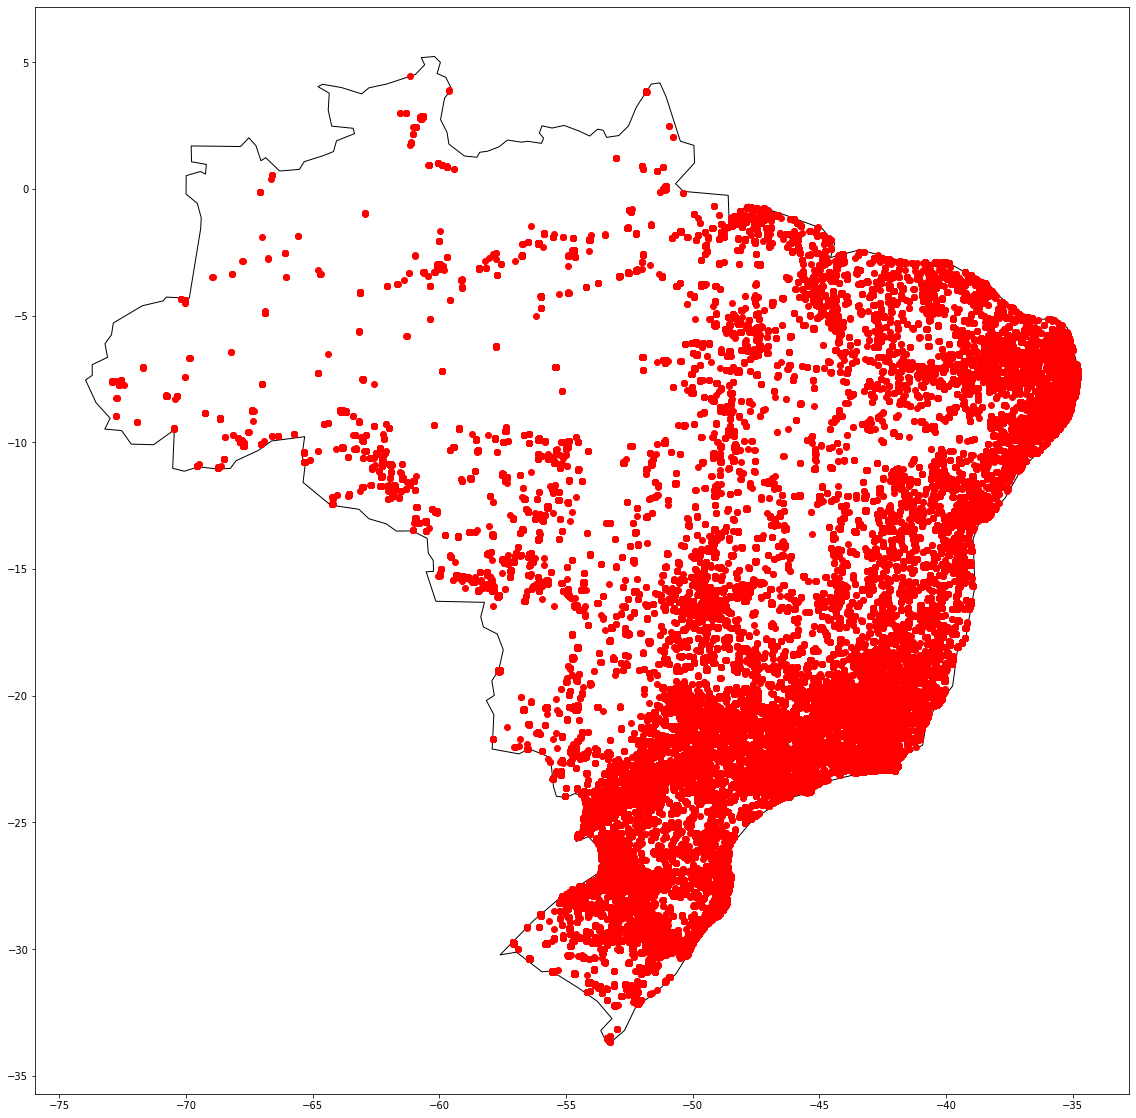

In [125]:
# Localização dos pedidos no Brasil
brazil_map = world_map[world_map['name'] == 'Brazil']
points_in_brazil = points.within(brazil_map.iloc[0]['geometry'])
ax = brazil_map.plot(color='white', edgecolor='black', figsize=(20,20))
points[points_in_brazil].plot(ax=ax, color='red')
plt.show()

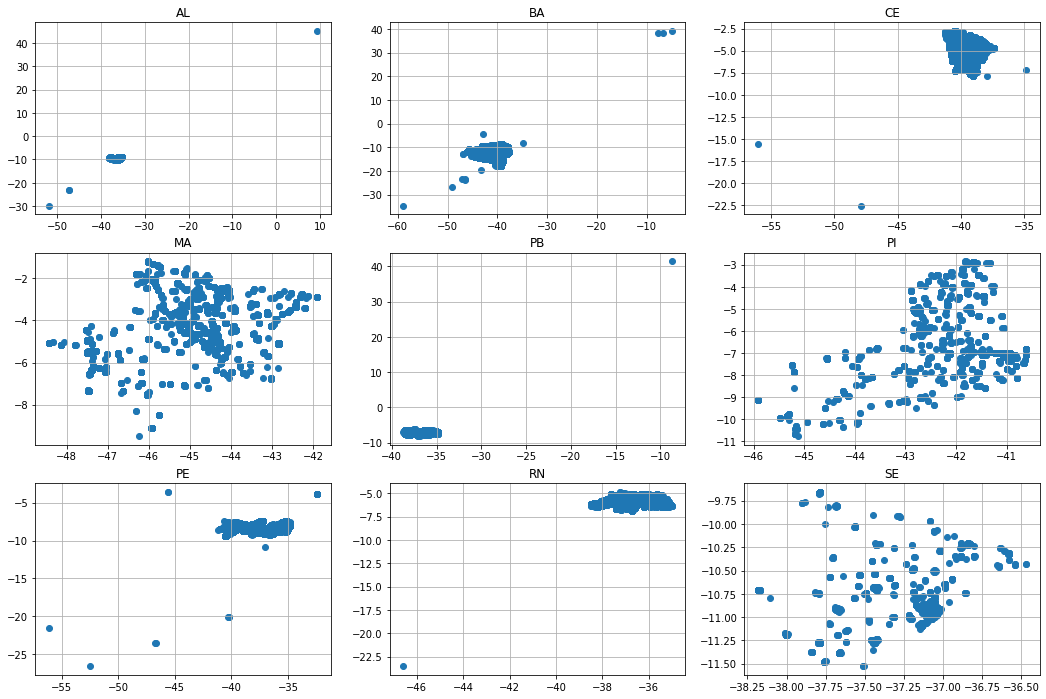

In [60]:
# Localização dos pedidos no nordeste
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(18, 12))
for i in range(len(nordeste)):
  axes[int(i/3)][i%3].scatter(geolocation[geolocation['geolocation_state'] == nordeste[i]]['geolocation_lng'], geolocation[geolocation['geolocation_state'] == nordeste[i]]['geolocation_lat'])
  axes[int(i/3)][i%3].set_title(nordeste[i])
  axes[int(i/3)][i%3].grid(True)

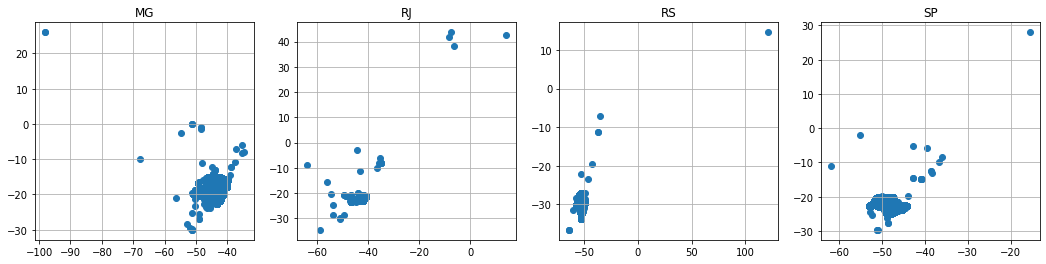

In [61]:
# Localização dos pedidos no sudeste
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(18, 4))
for i in range(len(sudeste)):
  axes[i].scatter(geolocation[geolocation['geolocation_state'] == sudeste[i]]['geolocation_lng'], geolocation[geolocation['geolocation_state'] == sudeste[i]]['geolocation_lat'])
  axes[i].set_title(sudeste[i])
  axes[i].grid(True)

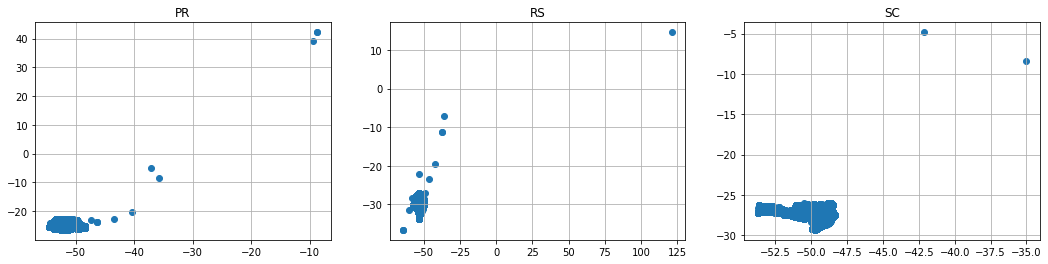

In [62]:
# Localização dos pedidos no sul
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 4))
for i in range(len(sul)):
  axes[i].scatter(geolocation[geolocation['geolocation_state'] == sul[i]]['geolocation_lng'], geolocation[geolocation['geolocation_state'] == sul[i]]['geolocation_lat'])
  axes[i].set_title(sul[i])
  axes[i].grid(True)

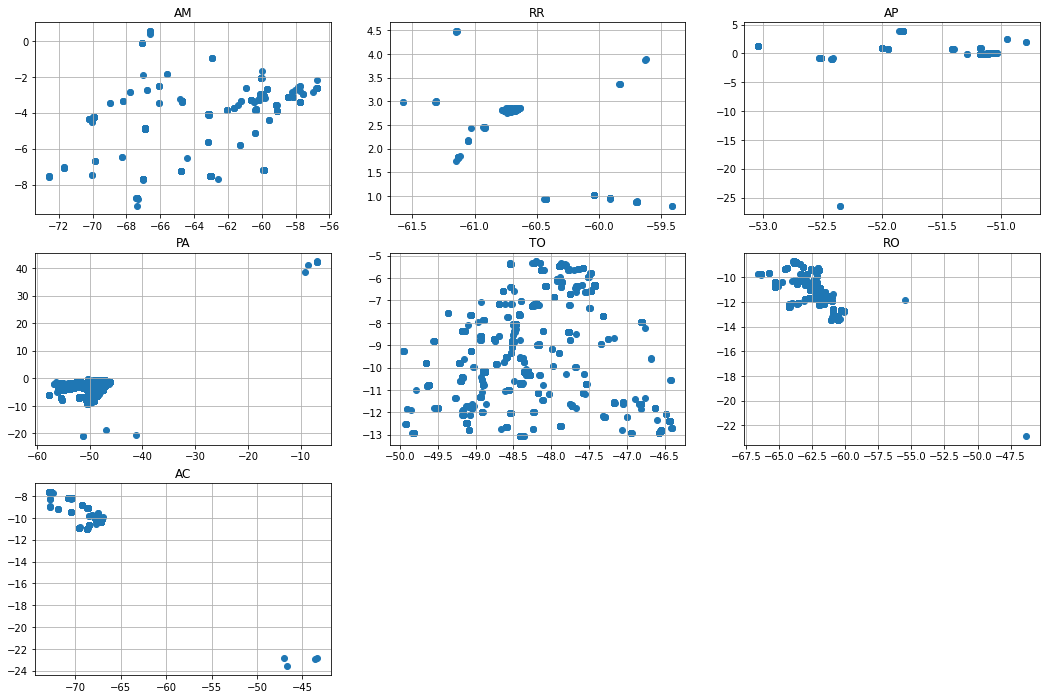

In [63]:
# Localização dos pedidos no norte
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(18, 12))
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])
for i in range(len(norte)):
  axes[int(i/3)][i%3].scatter(geolocation[geolocation['geolocation_state'] == norte[i]]['geolocation_lng'], geolocation[geolocation['geolocation_state'] == norte[i]]['geolocation_lat'])
  axes[int(i/3)][i%3].set_title(norte[i])
  axes[int(i/3)][i%3].grid(True)

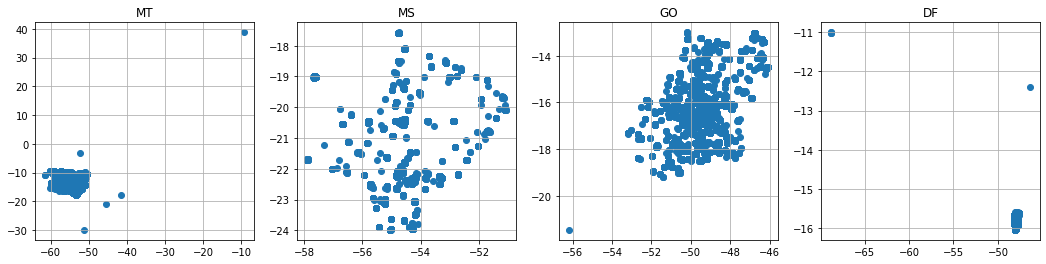

In [64]:
# Localização dos pedidos no centro_oeste
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(18, 4))
for i in range(len(centro_oeste)):
  axes[i].scatter(geolocation[geolocation['geolocation_state'] == centro_oeste[i]]['geolocation_lng'], geolocation[geolocation['geolocation_state'] == centro_oeste[i]]['geolocation_lat'])
  axes[i].set_title(centro_oeste[i])
  axes[i].grid(True)

Observe que em algums gráficos, alguns pontos encontram-se bem distantes da maior parte deles. Ocasionado por algum erro, visto que se trata de pontos fora dos estados. Vamos remover alguns destes pontos utilizando as técnicas de remoção de outliers multivariadas.

# Estudo sobre os pedidos

In [65]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Como existem muitas categorias, é interessante buscar aquelas cuja distribuição de alguma variável segue uma normal. Escolheremos a variável peso. E a seguir, plotaremos os respectivos boxplots e histogramas, evidenciando e o que foi suposto nos testes.

In [66]:
# Categorias com mais de 100 registros

top_frequency_categories = products['product_category_name'].value_counts()[products['product_category_name'].value_counts() > 100].index.tolist()
tests = []

In [67]:
for i in range(0, len(top_frequency_categories)):
  statistic, p_value = stats.shapiro(products[products['product_category_name'] == top_frequency_categories[i]]['product_weight_g'])
  x = float(statistic) 
  shapiro_test = {
      "statistic": statistic,
      "p_value": p_value,
      "category": top_frequency_categories[i]
  }
  if(not math.isnan(x)):
    tests.append(shapiro_test)

In [68]:
tests = sorted(tests, key=lambda k: k['statistic'], reverse=True)

In [69]:
tests[:5]

[{'statistic': 0.9565004110336304,
  'p_value': 5.9364559490404645e-08,
  'category': 'moveis_escritorio'},
 {'statistic': 0.821455717086792,
  'p_value': 5.790418144968612e-11,
  'category': 'climatizacao'},
 {'statistic': 0.7942505478858948,
  'p_value': 1.5457492057169286e-13,
  'category': 'moveis_sala'},
 {'statistic': 0.7345268130302429,
  'p_value': 7.057234571034021e-13,
  'category': 'casa_conforto'},
 {'statistic': 0.7223107218742371,
  'p_value': 2.287406425302009e-19,
  'category': 'eletroportateis'}]

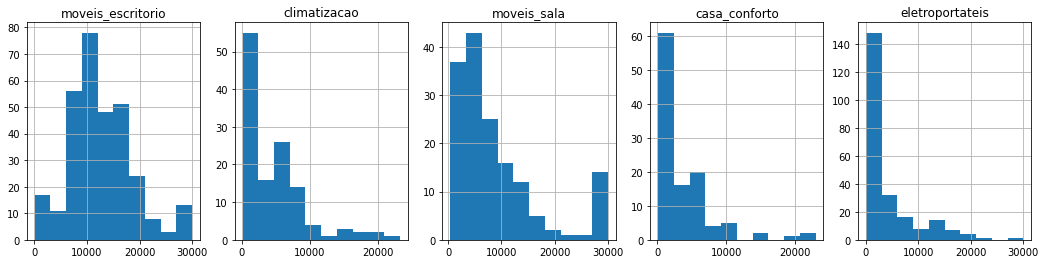

In [70]:
# Histogramas dos 5 principais testes
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18, 4))
for i in range(5):
  axes[i].hist(products[products['product_category_name'] == tests[:5][i]['category']]['product_weight_g'])
  axes[i].set_title(tests[:5][i]['category'])
  axes[i].grid(True)

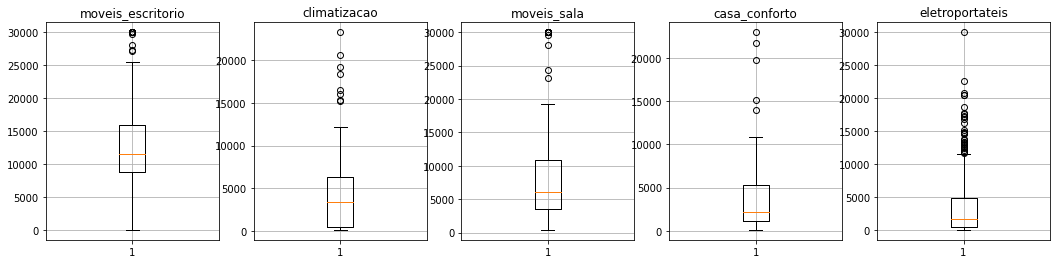

In [71]:
# Boxplot dos 5 principais testes
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18, 4))
for i in range(5):
  axes[i].boxplot(products[products['product_category_name'] == tests[:5][i]['category']]['product_weight_g'])
  axes[i].set_title(tests[:5][i]['category'])
  axes[i].grid(True)

Para cada uma das categorias descritas acima, vamos remover alguns outliers utilizando técnicas de remoção univariadas

# Removendo outlier utilizando z-score robusto

Para remover outliers, vamo escolher um subconjunto cuja distribuição dos dados esteja bastante esparsa. Por exemplo, escolheremos o 25º resultado dos testes obtidos na seção anterior.

In [72]:
from numpy import log10
pesos = products[products['product_category_name'] == tests[25]['category']]['product_weight_g']
print(len(pesos))

517


<AxesSubplot:>

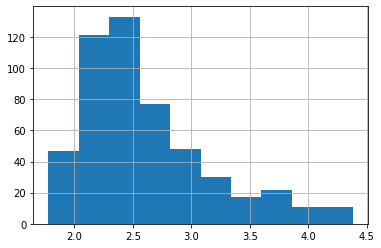

In [73]:
pesos_log = log10(pesos)
pesos_log.hist()

In [74]:
from numpy import abs
mad = abs(pesos_log - pesos_log.median()).median()*(1/0.6745)
print(mad)

0.3784618311390749


In [75]:
pesos_log.mad()

0.4375152664456083

<AxesSubplot:>

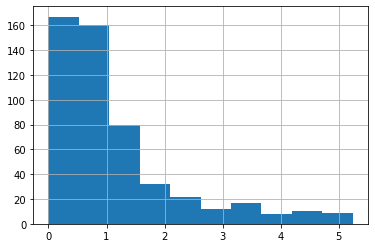

In [76]:
(abs(pesos_log - pesos_log.median())/mad).hist()

In [77]:
pesos_depois = pesos[abs(pesos_log - pesos_log.median())/mad < 3.5]
len(pesos_depois)

481

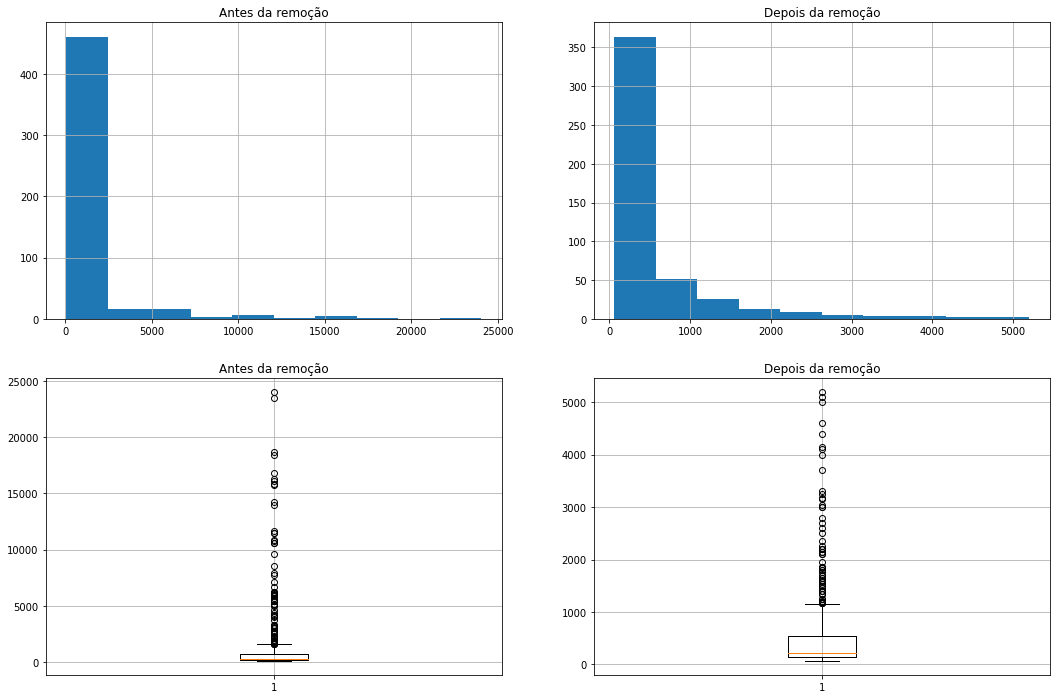

In [78]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 12))
axes[0][0].hist(pesos)
axes[0][0].set_title('Antes da remoção')
axes[0][0].grid(True)
axes[0][1].hist(pesos_depois)
axes[0][1].set_title('Depois da remoção')
axes[0][1].grid(True)
axes[1][0].boxplot(pesos)
axes[1][0].set_title('Antes da remoção')
axes[1][0].grid(True)
axes[1][1].boxplot(pesos_depois)
axes[1][1].set_title('Depois da remoção')
axes[1][1].grid(True)

# Removendo outliers utilizando método de tukey

Vamos escolher a mesma distribuição do caso anterior, a fim de comparar os resultados no final

In [79]:
pesos = products[products['product_category_name'] == tests[25]['category']]['product_weight_g']
print(len(pesos))

517


<AxesSubplot:>

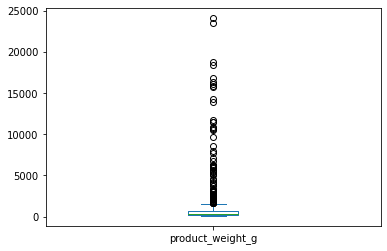

In [80]:
pesos.plot.box()

<AxesSubplot:>

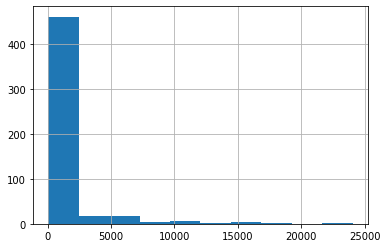

In [81]:
pesos.hist()

<AxesSubplot:>

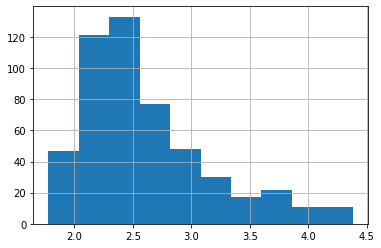

In [82]:
pesos_log = log10(pesos)
pesos_log.hist()

In [83]:
q1 = pesos_log.quantile(q=0.25)
q3 = pesos_log.quantile(q=0.75)
iqr = q3 - q1
print(iqr)

0.6806376313272011


In [84]:
pesos[pesos_log < (q1-1.5*iqr)]

Series([], Name: product_weight_g, dtype: float64)

In [85]:
pesos[pesos_log > (q3+1.5*iqr)]

656      24050.0
1178     16850.0
2688     11700.0
3027     16283.0
10273     7738.0
10538    15750.0
11384    10575.0
11483     7900.0
12928    10900.0
17922     8550.0
18161    23500.0
19647    10800.0
20513    11450.0
21810    13950.0
23870    11500.0
24219    15800.0
25810    18400.0
26780    10550.0
28602    18700.0
28847     9650.0
29990    14250.0
32876    16100.0
Name: product_weight_g, dtype: float64

In [86]:
pesos_depois = pesos[abs(pesos_log - pesos_log.median())/mad < 3.5]
len(pesos_depois)

481

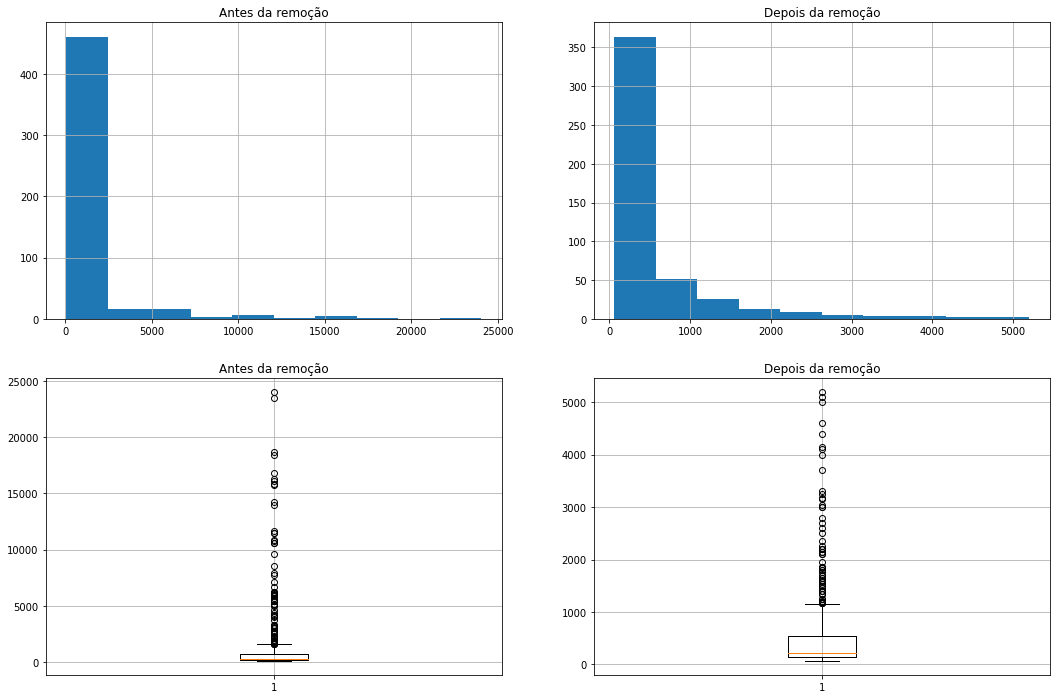

In [87]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 12))
axes[0][0].hist(pesos)
axes[0][0].set_title('Antes da remoção')
axes[0][0].grid(True)
axes[0][1].hist(pesos_depois)
axes[0][1].set_title('Depois da remoção')
axes[0][1].grid(True)
axes[1][0].boxplot(pesos)
axes[1][0].set_title('Antes da remoção')
axes[1][0].grid(True)
axes[1][1].boxplot(pesos_depois)
axes[1][1].set_title('Depois da remoção')
axes[1][1].grid(True)

Observe que para essa mesma distribuição de dados, o z-score robusto e o método de Tukey removem a mesma quantidade de dados.